# Spam Classifier with Apache SpamAssassin Dataset

In this project, I build a basic spam classifier using raw email files from the [Apache SpamAssassin public corpus](https://spamassassin.apache.org/old/publiccorpus/).

The goal is to:
- Parse and preprocess raw email data
- Convert email text into a usable feature vector
- Train and evaluate spam classification models

This notebook represents a learning exercise in working with real-world, unstructured text data. It involves:
- Reading raw `.txt` email files (not CSVs)
- Extracting useful content from headers and body
- Building a feature extraction pipeline from scratch
- Training multiple classifiers (e.g., Logistic Regression, Naive Bayes)

### Dataset Used:
- `20030228_easy_ham.tar.bz2`: ~2,500 ham (non-spam) emails
- `20030228_spam.tar.bz2`: ~500 spam emails


Let’s get started by inspecting the contents of a sample email.


In [2]:
import os
from email import policy
from email.parser import BytesParser
import re
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Exploring the Raw Emails

In [3]:
def extract_body(file_path):
    with open(file_path, "rb") as f:
        msg = BytesParser(policy=policy.default).parse(f)

    def safe_get_content(part):
        try:
            return part.get_content()
        except LookupError:
            # Fallback if encoding is invalid or unknown
            raw = part.get_payload(decode=True)
            return raw.decode("utf-8", errors="replace") if raw else ""

    if msg.is_multipart():
        body = msg.get_body(preferencelist=("plain",))
        return safe_get_content(body) if body else ""
    else:
        return safe_get_content(msg)




file_path = os.path.join("ham", os.listdir("ham")[0])
body = extract_body(file_path)
print(body[:500])

    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrac


**The body still has the parts of header from likely Forwarded message including headers (From, Date, etc.) Quoted text, signatures, or email footers. We will make a helper function to extract the body from it**

In [4]:
def strip_leading_headers(text):
    lines = text.splitlines()
    lines = [line.strip() for line in lines]
    cleaned_body = []
    header_pattern = r"^[A-Za-z\-]+:\s"
    for line in lines:
        if re.match(header_pattern, line):
            continue
        else:
            cleaned_body.append(line)

    return "\n".join(cleaned_body)

print(strip_leading_headers(body)[:500])




| I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run t


**Email cleaning**

In [5]:
def clean_email_text(text):
    # Lowercase
    text = text.lower()

    # Remove email quotes (lines starting with > or |)
    text = "\n".join(line for line in text.splitlines() if not re.match(r"^(>|\|)", line))

    # Remove URLs
    text = re.sub(r"https?://\S+|www\.\S+", "URL", text)

    # Remove email addresses
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b", "EMAIL", text)

    # Remove special characters/punctuation
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text


### We will apply the above functions to all the emails and save it with their respective labels

In [6]:
def process_folder(folder_name, label):
    
    data = []
    for filename in os.listdir(folder_name):
        file_path = os.path.join(folder_name, filename)
        try:
            raw_body = extract_body(file_path)
            stripped_body = strip_leading_headers(raw_body)
            clean_body = clean_email_text(stripped_body)
            data.append((clean_body, label))
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue
    
    return data

In [7]:
ham_data = process_folder("ham", label=0)
spam_data = process_folder("spam", label=1)

all_emails = ham_data + spam_data

print(f"Total emails processed: {len(all_emails)}")

Total emails processed: 3002


## Seperating data for training

In [8]:
texts, labels = zip(*all_emails)

X_train, X_test, y_train, y_test = train_test_split(texts, labels, random_state=42, test_size=0.2)

## Feature Vectorization

After splitting our emails into training and test sets, the next step is to **convert the text data into numbers** that machine learning models can understand.

We’ll use a technique called **feature vectorization** which:

- Builds a vocabulary of all words in the training emails
- Represents each email as a vector showing how often each word appears (or simply if it appears)
- This vectorized data can then be fed into classifiers to learn patterns and predict spam or ham

Think of it as translating human language into a numerical format the machine can work with.

In [9]:
vectorizer = CountVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)

X_test_vec = vectorizer.transform(X_test)


## Fitting it to the model

When building our spam classifier, we will use a **pipeline** that combines the text vectorization step (`CountVectorizer`) with the classification model (e.g., Logistic Regression).

**Why?**

- To ensure the vectorizer is **fit only on the training data** during cross-validation or train-test split.
- Prevents **data leakage** — where information from the test data accidentally influences the training process.
- Guarantees that transformations are applied consistently and correctly during training and testing.
- Simplifies code by chaining preprocessing and model training into one step.

Using a pipeline is a best practice to maintain the integrity of model evaluation.

In [10]:
pipeline_cv = Pipeline([
    ("counter_vectorizer", CountVectorizer()),
    ("log_reg", LogisticRegression(max_iter=1000))
])

scores = cross_val_score(pipeline_cv, X_train, y_train, cv=3, scoring="accuracy")
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation accuracy scores: [0.98002497 0.96625    0.97375   ]
Mean accuracy: 0.9733416562630045


When classes are imbalanced (e.g., way more ham than spam emails), accuracy alone can be misleading. We will calculate the **f1_score** and **confusion matrix** to evaluate the model performance

In [11]:
y_train_pred = cross_val_predict(pipeline_cv, X_train, y_train, cv=3)
conf_mx_cv = confusion_matrix(y_train, y_train_pred)
print(conf_mx_cv)

cv_reg_pr = precision_score(y_train, y_train_pred)
cv_reg_rec = recall_score(y_train, y_train_pred)
cv_reg_f1 = f1_score(y_train, y_train_pred)

print(f"\nPrecision score: {cv_reg_pr :.4f} \nRecall score: {cv_reg_rec :.4f} \nf1_score: {cv_reg_f1 :.4f}")

[[1997    7]
 [  57  340]]

Precision score: 0.9798 
Recall score: 0.8564 
f1_score: 0.9140


### Applying Tfid Vectorizer

In [12]:
pipeline_tfid = Pipeline([
    ("tfd_vec", TfidfVectorizer()),
    ("log_reg", LogisticRegression(max_iter=1000))
])

scores = cross_val_score(pipeline_tfid, X_train, y_train, cv=3, scoring="accuracy")
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation accuracy scores: [0.94881398 0.94625    0.95125   ]
Mean accuracy: 0.9487713275072825


In [13]:
y_train_pred = cross_val_predict(pipeline_tfid, X_train, y_train, cv=3)
conf_mx_tfid = confusion_matrix(y_train, y_train_pred)
print(conf_mx_tfid)

tfid_reg_pr = precision_score(y_train, y_train_pred)
tfid_reg_rec = recall_score(y_train, y_train_pred)
tfid_reg_f1 = f1_score(y_train, y_train_pred)

print(f"\nPrecision score: {tfid_reg_pr :.4f} \nRecall score: {tfid_reg_rec :.4f} \nf1_score: {tfid_reg_f1 :.4f}")

[[2003    1]
 [ 122  275]]

Precision score: 0.9964 
Recall score: 0.6927 
f1_score: 0.8172


**TF-IDF improved overall precision but reduced recall. This shows our classifier is cautious, catching fewer spam emails but almost never mislabeling ham.**

### Computing and plotting roc curve

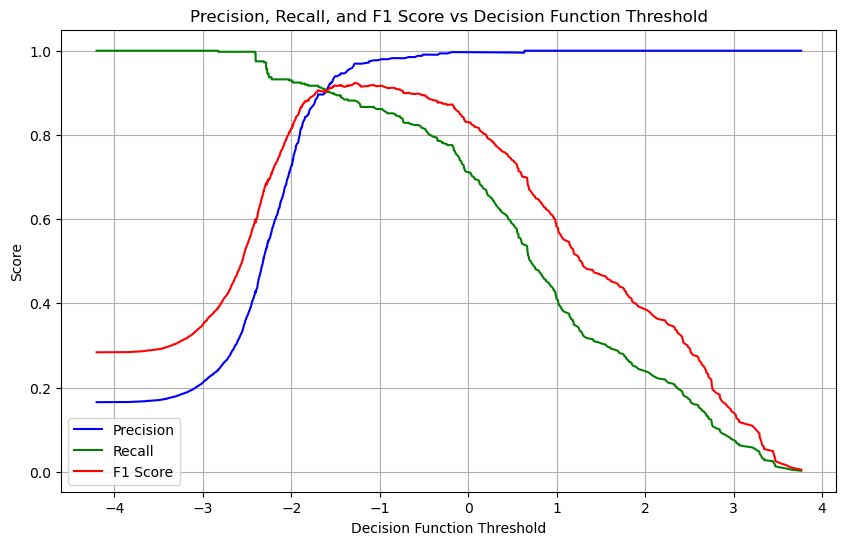

In [14]:
# Get scores using CV on training set
y_train_scores = cross_val_predict(pipeline_tfid, X_train, y_train, cv=5, method="decision_function")


# Calculate precision, recall, and threshold
precision, recall, thresholds = precision_recall_curve(y_train, y_train_scores)

# Align lengths for plotting.
precision = precision[:-1]
recall = recall[:-1]

f1_scores = 2 * (precision * recall) / (precision + recall)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label='Precision', color='blue')
plt.plot(thresholds, recall, label='Recall', color='green')
plt.plot(thresholds, f1_scores, label='F1 Score', color='red')
plt.xlabel('Decision Function Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Decision Function Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
desired_recall = 0.85

high_recall_indices = np.where(recall >= desired_recall)[0]

best_idx = high_recall_indices[np.argmax(f1_scores[high_recall_indices])]

print(f"Best threshold with recall >= {desired_recall}: {thresholds[best_idx]:.3f}")
print(f"Precision at this threshold: {precision[best_idx]:.3f}")
print(f"Recall at this threshold: {recall[best_idx]:.3f}")
print(f"F1 score at this threshold: {f1_scores[best_idx]:.3f}")

Best threshold with recall >= 0.85: -1.282
Precision at this threshold: 0.970
Recall at this threshold: 0.882
F1 score at this threshold: 0.923


Now the best threshold value we have is **-1.282** We can apply it to our classifier

In [18]:
best_threshold = -1.282

# Refit the pipeline
pipeline_tfid.fit(X_train, y_train)

# Get test decision scores
y_test_scores = pipeline_tfid.decision_function(X_test)

# Apply the tuned threshold
y_test_pred = (y_test_scores >= best_threshold).astype(int)

# Create confusion matrix
conf_mx_tfid_customTH = confusion_matrix(y_test, y_test_pred)

print("Confusion Matrix:")
print(conf_mx_tfid_customTH)

custom_th_tfid_pr = precision_score(y_test, y_test_pred)
custom_th_tfid_rec = recall_score(y_test, y_test_pred)
custom_th_tfid_f1 = f1_score(y_test, y_test_pred)

print(f"\nPrecision score: {custom_th_tfid_pr :.4f} \nRecall score: {custom_th_tfid_rec :.4f} \nf1_score: {custom_th_tfid_f1 :.4f}")


Confusion Matrix:
[[494   3]
 [ 12  92]]

Precision score: 0.9684 
Recall score: 0.8846 
f1_score: 0.9246


## Comparison

In [ ]:
data = {
    "Precision": [cv_reg_pr, tfid_reg_pr, custom_th_tfid_pr],
    "Recall": [cv_reg_rec, tfid_reg_rec, custom_th_tfid_rec],
    "f1_scores": [cv_reg_f1, tfid_reg_f1, custom_th_tfid_f1]
}

df = pd.DataFrame(data, index=["CV + LR", "TFIDF + LR", "TFIDF + LR (Thresh)"])

print(df)



                     Precision    Recall  f1_scores
CV + LR               0.979827  0.856423   0.913978
TFIDF + LR            0.996377  0.692695   0.817236
TFIDF + LR (Thresh)   0.968421  0.884615   0.924623


Among the three models evaluated, **TFIDF + LR with a custom threshold** achieves the best balance between precision and recall, reflected in the highest F1 score (0.9246). While TFIDF + LR has the highest precision (0.9964), its recall is noticeably lower (0.693), indicating it misses more positive cases. CV + LR maintains solid performance across both metrics but is slightly outperformed by the threshold-tuned TFIDF model.

Overall, adjusting the decision threshold allows us to optimize the trade-off between precision and recall, making **TFIDF + LR (Thresh)** the most effective choice for this classification task.